# Landslide runout analysis with WhiteboxTools

In this notebook, an analysis of landslide runout areas is performed for a location close to Odda. The area of interest was randomly selected.

First, landslide start cells are identified using NGU's method [1]. NGU's method (binary logic) is chosen for the sake of simplicity in this example. In my Master's thesis, I argue in favour of fuzzy logic instead.

Second, a runout analysis is performed with the same tools I used for my Master's thesis, namely the WhiteboxTools package. WhiteboxTools is a popular platform for geospatial data anlysis and was used for most DEM-related calculations in my thesis.

The flow algorithm of WhiteboxTools ("D-Inf") has some disadvantages compared to the flow algorithm in NGU's runout mapping ("Multiple Flow Direction"), such as restricting divergence of debris fans [2]. A comparison of NGU's runout modelling process and the one presented here can be found in this repository's *README.md* file.

### References

[1] "Aktsomhetskart jord- og flomskred: Metodeutvikling og landsdekkende modellering". NGU (2014)

[2] "Debris ﬂow susceptibiliy mapping at a regional scale". Horton et al. (2008)

### 1. Imports

In [2]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import rasterio as rio
import whitebox

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from rasterio import shutil as rshutil

### 2. File directory and file names

In [192]:
data_dir = "data"

dem = "dtm10_selection.tif"
filled = "filled.tif"
curvature = "plan_curvature.tif"
flacc = "flow_accum.tif"
slope = "slope.tif"
start = "start_cells.tif"
efficiency = "efficiency.tif"
absorption = "absorption.tif"
runout = "runout.tif"

### 3. Load WhiteboxTools interfacing objects and configure working directory

In [193]:
wbt = whitebox.WhiteboxTools()
wbt.set_verbose_mode(False)

cwd = os.getcwd()
wbt_dir = os.path.join(cwd, data_dir)
wbt.set_working_dir(wbt_dir)

### 4. Create rasters

- Fill depressions in DTM
- Plan curvature [*1/m*]
- D-Inf flow accumulation [*m2*] (same flow algorithm as in Master's thesis)
- Slope [*deg*]

NGU identifies start cells of debris flow by combining threshold values for plan curvature, flow accumulation and slope angle [1]. In this step, the necessary rasters are calculated from the digital elevation model (after filling depressions).

In [194]:
wbt.fill_depressions(
    dem, 
    filled, 
    fix_flats=False, 
    flat_increment=None, 
    max_depth=None
)

0

In [195]:
wbt.plan_curvature(
    filled, 
    curvature, 
    log=False, 
    zfactor=None
)

0

In [196]:
wbt.d_inf_flow_accumulation(
    filled, 
    flacc, 
    out_type="ca", 
    threshold=None, 
    log=False, 
    clip=False, 
    pntr=False
)

0

In [197]:
wbt.slope(
    filled, 
    slope, 
    zfactor=None, 
    units="degrees"
)

0

### 5. Identify start cells

Threshold values for curvature, flow accumulation and slope are similar to those used in NGU's regional analysis

In [198]:
MAX_CURVATURE = -0.05 # [1/m]
MIN_FLOW_ACC = 5000 # [m2]
MIN_SLOPE, MAX_SLOPE = 25, 45 # [deg]

In [199]:
def read_data(raster_file: str, band: int = 1) -> np.ndarray:
    """Read raster file data on specified band"""
    raster = rio.open(raster_file)
    return raster.read(band)

In [213]:
# reading data into 2D numpy arrays
curvature_array = read_data(os.path.join(data_dir, curvature))
flacc_array = read_data(os.path.join(data_dir, flacc))
slope_array = read_data(os.path.join(data_dir, slope))

Mask cells with threshold values and combine parameters

In [214]:
# applying masks
curvature_mask = np.where(curvature_array <= MAX_CURVATURE, 1, 0)
flacc_mask = np.where(flacc_array >= MIN_FLOW_ACC, 1, 0)
slope_mask = np.where(((slope_array >= MIN_SLOPE) & (slope_array <= MAX_SLOPE)), 1, 0)

In [215]:
# identifying start cells with raster calculation
start_cells = curvature_mask + flacc_mask + slope_mask
start_cells = np.where(start_cells == start_cells.max(), 1, 0)

Plot start cells

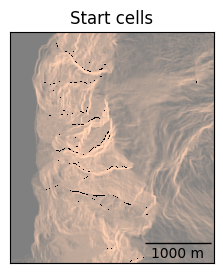

In [210]:
masked_cells = np.ma.masked_where(start_cells < 1, start_cells)

fig, ax = plt.subplots()
ax.imshow(slope_array, cmap=cm.copper, alpha=0.5)
ax.imshow(masked_cells, cmap=cm.gray, interpolation="none")

scalebar = AnchoredSizeBar(
    ax.transData,
    100,
    "1000 m",
    "lower right", 
    pad=0.1,
    color="black",
    frameon=False,
    size_vertical=1
)
ax.add_artist(scalebar)

plt.xticks([]) 
plt.yticks([]) 
plt.title("Start cells")
plt.show()

In [218]:
# save start cell raster
rshutil.copy(os.path.join(data_dir, dem),os.path.join(data_dir, start))
with rio.open (os.path.join(data_dir, start), "r+") as raster:
    raster.write (start_cells, indexes = 1)

### 6. Runout modelling

Efficiency and absorption rasters

Efficiency (as percentage) describes a cell's ability to route mass flux towards neighbouring child cells. 100% efficiency = the entire mass will be directed towards downstream cells

Absorption (as quantity) is the amount of mass flux that is absorbed in a cell.

These two parameters allow for the runout model to take vegetation and infrastructure into account by adjusting efficiency and/ or absorption in corresponding cells.

Since no comparable values are available, efficiency is assumed to be 1 and absorption to be 0, i.e. cells are inert and do not restrict mass flux spread ("worst-case scenario").

In [211]:
def mask_everything(raster_in: str, raster_out: str, mask_value: float, band: int = 1) -> None:
    "Copy raster metadata and overwrite cells with constant value"
    rshutil.copy(raster_in,raster_out)
    with rio.open (raster_out, "r+") as raster:
        data = raster.read(band)
        data.fill(mask_value)
        raster.write (data, indexes = band)

In [216]:
# call mask_everything and create efficiency and absorption rasters
fill_dict = {
    efficiency: 1,
    absorption: 0
}

for k, v in fill_dict.items():
    mask_everything(
        os.path.join(data_dir, dem),
        os.path.join(data_dir, k),
        v
    )

In [217]:
# create D-Inf mass flux raster
wbt.d_inf_mass_flux(
    filled, 
    start, 
    efficiency, 
    absorption, 
    runout
)

0

Plot runout cells

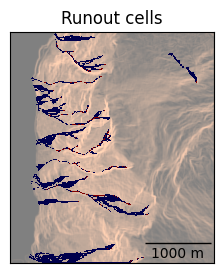

In [209]:
runout_cells = read_data(os.path.join(data_dir, runout))
masked_cells = np.ma.masked_where(runout_cells < 0.01, start_cells)

fig, ax = plt.subplots()
ax.imshow(slope_array, cmap=cm.copper, alpha=0.5)
ax.imshow(masked_cells, cmap=cm.seismic, interpolation="none")

scalebar = AnchoredSizeBar(
    ax.transData,
    100,
    "1000 m",
    "lower right", 
    pad=0.1,
    color="black",
    frameon=False,
    size_vertical=1
)
ax.add_artist(scalebar)

plt.xticks([]) 
plt.yticks([]) 
plt.title("Runout cells")
plt.show()